In [73]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import tensorflowjs as tfjs

os.environ["KERAS_BACKEND"] = "tensorflow"

In [74]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

5

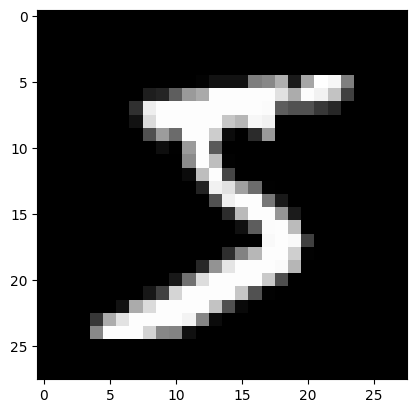

In [75]:
plt.imshow(x_train[0], cmap="gray")
y_train[0]

In [113]:
def sampler(x):
    [log_var, mean] = keras.ops.split(x, 2, axis=-1)
    stddev = ops.exp(0.5*log_var)
    batch = ops.shape(mean)[0]
    dim = ops.shape(mean)[1]
    eps = keras.random.normal(shape=(batch, dim))
    z = mean + eps*stddev
    return z, mean, log_var

class VAE(keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(128, activation="relu"),
            layers.Dense(latent_dim*2) # mu and sigmas (this could also be written as two separate dense layers, but combined for tfjs)
        ])
        self.decoder = keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(784, activation="sigmoid")
        ])

    def call(self, x):
        x = self.encoder(x)
        z, mean, log_var = sampler(x)
        recon = self.decoder(z)
        return recon, z, mean, log_var

class Trainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_term_tracker = keras.metrics.Mean(name="kl_term")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_term_tracker, self.total_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = self.flatten(data)
            x_hat, _, mean, log_var = self.model(x)
            kl_term = -0.5*(ops.sum(1 + log_var - mean**2 - ops.exp(log_var), axis=-1))
            recon = ops.sum((x-x_hat)**2, axis=-1)
            loss = ops.mean(recon) + 0.3*ops.mean(kl_term)
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_term_tracker.update_state(kl_term)
        self.total_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_term": self.kl_term_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


ae = VAE(latent_dim=8)
t = Trainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=30, batch_size=128)

/usr/local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_term: 17.4378 - reconstruction_loss: 61.5497 - total_loss: 66.7810
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 14.7557 - reconstruction_loss: 26.1395 - total_loss: 30.5662
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 14.6091 - reconstruction_loss: 23.5458 - total_loss: 27.9285
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 14.7248 - reconstruction_loss: 22.2309 - total_loss: 26.6483
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 14.9190 - reconstruction_loss: 21.4401 - total_loss: 25.9159
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 15.0323 - reconstruction_loss: 20.8406 - total_loss: 25.3502
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_term: 15.1746 - reconstruction_loss: 20.2883 - total_loss: 24.8407
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_term: 15.3085 - reconstruction_loss: 19.9050 - total_loss: 24.4975
Epoch 9/

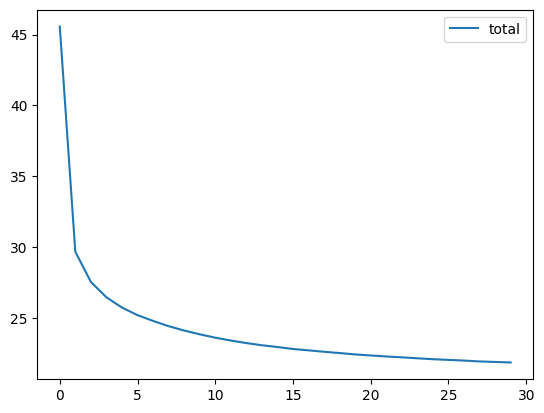

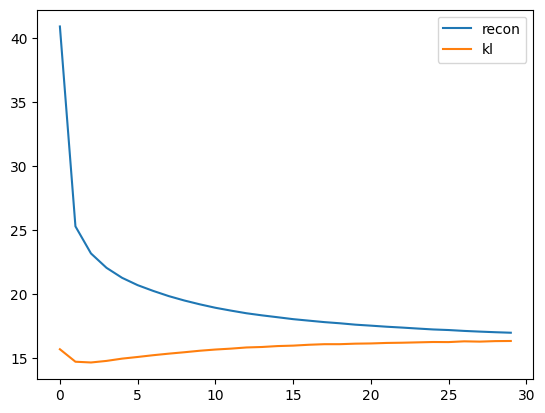

In [114]:
plt.plot(t.history.history["total_loss"], label="total")
plt.legend()
plt.show()
plt.plot(t.history.history["reconstruction_loss"], label="recon")
plt.plot(t.history.history["kl_term"], label="kl")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


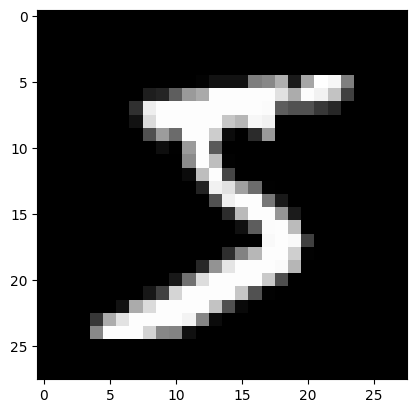

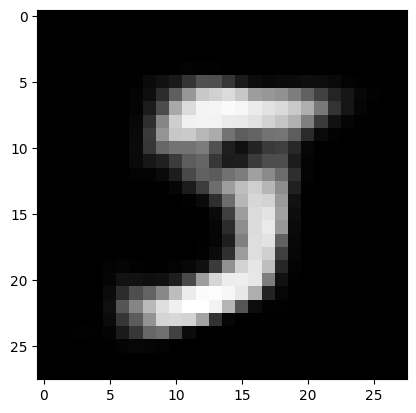

In [116]:
i = 0
recon, _, _, _ = ae.predict(x_train[i].reshape(-1, 784))
plt.imshow(x_train[i], cmap="gray")
plt.show()
plt.imshow(recon.reshape((28, 28)), cmap="gray")

In [117]:
tf.saved_model.save(ae.encoder, "models/encoder")
tf.saved_model.save(ae.decoder, "models/decoder")
tfjs.converters.convert_tf_saved_model("models/encoder", "models/tfjs/encoder")
tfjs.converters.convert_tf_saved_model("models/decoder", "models/tfjs/decoder")

INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets
2024-09-02 19:58:53.767445: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-09-02 19:58:53.885600: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
